In [4]:
!pip install python_speech_features

In [5]:
!pip install sounddevice

In [6]:
!pip install pyaudio

In [7]:
pip install librosa scikit-learn python_speech_features sounddevice tqdm

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install sounddevice

Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install resampy

In [2]:
!pip install --upgrade librosa

In [3]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from python_speech_features import mfcc
from tqdm import tqdm
#import sounddevice as sd

In [4]:
import librosa
import numpy as np

# Function to extract MFCC features
def extract_mfcc_features(audio, sr=16000, num_cepstral=13, frame_length=0.02, frame_stride=0.02,
                           num_filters=32, fft_length=320, preemphasis_coeff=0.98):
    # Apply pre-emphasis
    audio = np.append(audio[0], audio[1:] - preemphasis_coeff * audio[:-1])

    # Compute the short-time Fourier transform (STFT)
    hop_length = int(frame_stride * sr)
    n_fft = fft_length
    window = "hann"  # You can choose a different window function if needed
    stft_result = librosa.core.stft(audio, hop_length=hop_length, n_fft=n_fft, window=window)

    # Compute the mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(S=np.abs(stft_result)**2, sr=sr, n_mels=num_filters)

    # Logarithm of the mel spectrogram
    log_mel_energy = np.log(mel_spectrogram + 1e-9)

    # Extract MFCC features using DCT
    mfcc_features = librosa.feature.mfcc(S=log_mel_energy, n_mfcc=num_cepstral)

    # Apply mean and variance normalization across time
    mfcc_features = librosa.util.normalize(mfcc_features, norm=2, axis=0, fill=True)

    return mfcc_features

In [5]:
def preprocess_data(data_dir):
    data = []
    labels = []
    features = []

    for class_label in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_label)
        for file_name in tqdm(os.listdir(class_path), desc=f"Processing {class_label}"):
            file_path = os.path.join(class_path, file_name)
            audio, _ = librosa.load(file_path, sr = 16000)

            # Simply append the raw audio data to the dataset
            data.append({
                'audio': audio,
                'label': class_label
            })
            mfcc_features = extract_mfcc_features(audio)
            features.append(mfcc_features)
            labels.append(class_label)

    features = np.array(features)
    labels = np.array(labels)
    classes = set(labels)

     #Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    return features ,classes ,(X_train, y_train), (X_test, y_test)
# Example usage
data_dir = "/Users/doctorranjan/Desktop/yp/hackathon/Dataset"

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, LSTM, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import regularizers

def train_model(X_train, y_train, num_classes, X_test, y_test):
    encoder = LabelEncoder()
    encoded_labels_train = encoder.fit_transform(y_train)
    encoded_labels_test = encoder.transform(y_test)
    
    model = tf.keras.Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Reshape((13, -1)),
        LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), return_sequences=True),
        Dropout(0.25),
        Flatten(),
        Dense(num_classes, activation='sigmoid')])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, encoded_labels_train, epochs=50, batch_size=32, validation_data=(X_test, encoded_labels_test))
    
    return model, encoder

# Assuming you have features, classes, (X_train, y_train), (X_test, y_test) from preprocess_data

features, classes, (X_train, y_train), (X_test, y_test) = preprocess_data(data_dir)
num_classes = len(classes)

# Train the model
model, encoder = train_model(X_train, y_train, num_classes, X_test, y_test)




2024-01-07 09:22:24.901455: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Processing door_close: 100%|███████████████| 3503/3503 [00:24<00:00, 140.46it/s]


Epoch 1/50
317/317 [==============================] - 9s 16ms/step - loss: 1.0488 - accuracy: 0.5530 - val_loss: 0.7704 - val_accuracy: 0.7325
Epoch 2/50
317/317 [==============================] - 4s 13ms/step - loss: 0.6570 - accuracy: 0.7653 - val_loss: 0.4871 - val_accuracy: 0.8556
Epoch 3/50
317/317 [==============================] - 4s 13ms/step - loss: 0.5214 - accuracy: 0.8325 - val_loss: 0.4108 - val_accuracy: 0.8765
Epoch 4/50
317/317 [==============================] - 4s 12ms/step - loss: 0.4706 - accuracy: 0.8537 - val_loss: 0.3766 - val_accuracy: 0.8880
Epoch 5/50
317/317 [==============================] - 4s 13ms/step - loss: 0.4266 - accuracy: 0.8749 - val_loss: 0.3287 - val_accuracy: 0.9045
Epoch 6/50
317/317 [==============================] - 4s 12ms/step - loss: 0.4386 - accuracy: 0.8752 - val_loss: 0.3300 - val_accuracy: 0.9132
Epoch 7/50
317/317 [==============================] - 5s 16ms/step - loss: 0.4003 - accuracy: 0.8863 - val_loss: 0.3752 - val_accuracy: 0.8915

80/80 [==============================] - 1s 5ms/step
Accuracy: 93.02%
Precision: 93.01%
Recall: 93.02%
F1 Score: 93.01%


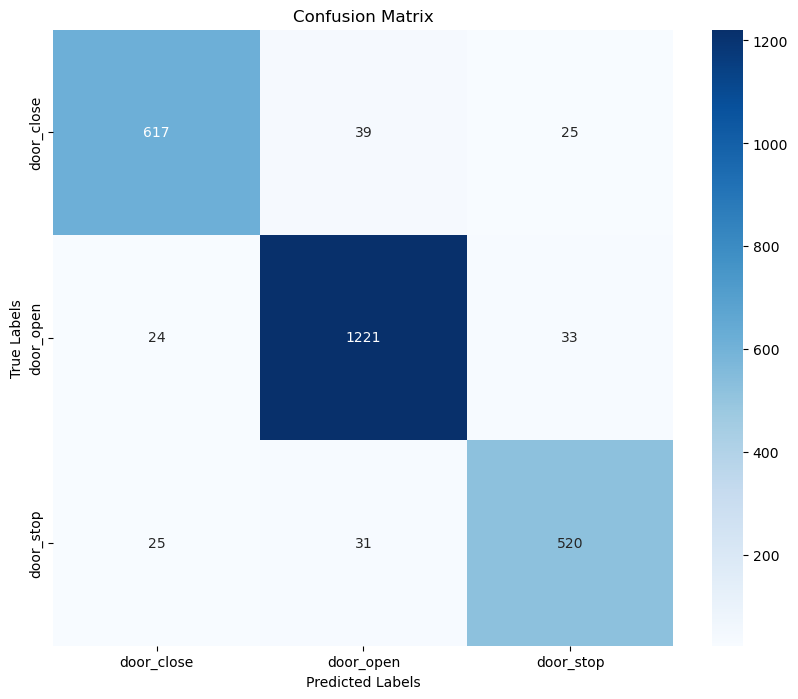

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate and print multiple evaluation metrics
def evaluate_model(model, X_test, y_test, label_encoder):
    # Predictions on test set
    y_pred = model.predict(X_test)
    

    # Convert predictions to class labels
    y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred_labels)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Calculate and print precision, recall, and F1 score
    precision = precision_score(y_test, y_pred_labels, average='weighted')
    recall = recall_score(y_test, y_pred_labels, average='weighted')
    f1 = f1_score(y_test, y_pred_labels, average='weighted')

    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels, labels=label_encoder.classes_)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Assuming you have the trained_model, X_test, y_test, and label_encoder
evaluate_model(model, X_test, y_test, encoder)


In [10]:
model.save('models/LSTM_trial_model.h5')

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, LSTM, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import regularizers
import numpy as np


def train_model(X_train, y_train, num_classes, X_test, y_test):
    encoder = LabelEncoder()
    encoded_labels_train = encoder.fit_transform(y_train)
    encoded_labels_test = encoder.transform(y_test)
    
    # Add 'None' class to the list of classes
    classes_with_none = np.append(encoder.classes_, 'None')
    
    # Fit label encoder with the extended list of classes
    encoder.fit(classes_with_none)
    
    # Transform labels to include 'None'
    encoded_labels_train = encoder.transform(y_train)
    encoded_labels_test = encoder.transform(y_test)
    
    model = tf.keras.Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Reshape((13, -1)),
        LSTM(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), return_sequences=True),
        Dropout(0.25),
        Flatten(),
        Dense(num_classes, activation='sigmoid')])
    
    model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, encoded_labels_train, epochs=30, batch_size=32, validation_data=(X_test, encoded_labels_test))
    
    return model, encoder

# Assuming you have features, classes, (X_train, y_train), (X_test, y_test) from preprocess_data
# Ensure that your labels include a "None" class
features, classes, (X_train, y_train), (X_test, y_test) = preprocess_data(data_dir)
num_classes = len(classes) + 1  # Add 1 for the "None" class

# Train the model
model, encoder = train_model(X_train, y_train, num_classes, X_test, y_test)


Processing door_close: 100%|███████████████| 3503/3503 [00:24<00:00, 140.61it/s]


Epoch 1/30
317/317 [==============================] - 8s 14ms/step - loss: 0.8969 - accuracy: 0.6240 - val_loss: 0.7079 - val_accuracy: 0.7436
Epoch 2/30
317/317 [==============================] - 4s 13ms/step - loss: 0.6367 - accuracy: 0.7823 - val_loss: 0.5718 - val_accuracy: 0.8209
Epoch 3/30
317/317 [==============================] - 5s 14ms/step - loss: 0.4978 - accuracy: 0.8479 - val_loss: 0.3842 - val_accuracy: 0.8836
Epoch 4/30
317/317 [==============================] - 4s 12ms/step - loss: 0.4478 - accuracy: 0.8650 - val_loss: 0.3780 - val_accuracy: 0.8978
Epoch 5/30
317/317 [==============================] - 4s 11ms/step - loss: 0.4127 - accuracy: 0.8839 - val_loss: 0.3919 - val_accuracy: 0.8864
Epoch 6/30
317/317 [==============================] - 4s 13ms/step - loss: 0.3857 - accuracy: 0.8882 - val_loss: 0.3799 - val_accuracy: 0.9014
Epoch 7/30
317/317 [==============================] - 4s 13ms/step - loss: 0.4068 - accuracy: 0.8905 - val_loss: 0.3838 - val_accuracy: 0.9199

80/80 [==============================] - 1s 6ms/step
Accuracy: 92.98%
Precision: 93.43%
Recall: 92.98%
F1 Score: 93.02%


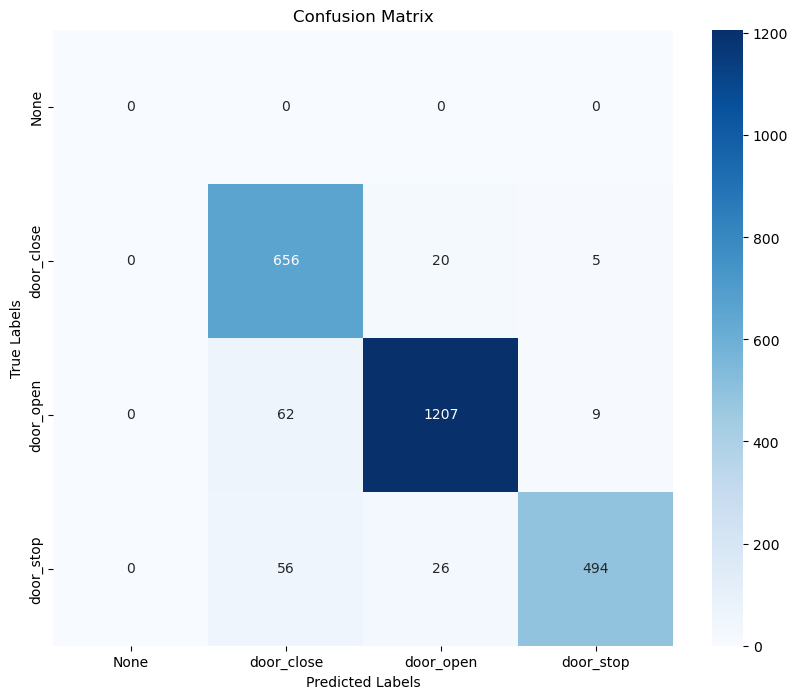

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate and print multiple evaluation metrics
def evaluate_model(model, X_test, y_test, label_encoder):
    # Predictions on test set
    y_pred = model.predict(X_test)
    

    # Convert predictions to class labels
    y_pred_labels = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

    # Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred_labels)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    # Calculate and print precision, recall, and F1 score
    precision = precision_score(y_test, y_pred_labels, average='weighted')
    recall = recall_score(y_test, y_pred_labels, average='weighted')
    f1 = f1_score(y_test, y_pred_labels, average='weighted')

    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels, labels=label_encoder.classes_)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Assuming you have the trained_model, X_test, y_test, and label_encoder
evaluate_model(model, X_test, y_test, encoder)


In [16]:
model.save('models/LSTM2_trial_model.h5')

In [19]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [20]:
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def train_cnn_model(X_train, y_train, num_classes, X_test, y_test):
    encoder = LabelEncoder()
    encoded_labels_train = encoder.fit_transform(y_train)
    encoded_labels_test = encoder.transform(y_test)

    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Reshape((X_train.shape[1], X_train.shape[2], 1)),
        layers.Conv2D(8, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    model.fit(X_train, encoded_labels_train, epochs=100, batch_size=32, validation_data=(X_test, encoded_labels_test))

    model.save("custom_model.keras")

    return model, encoder

# Assuming you have features, classes, (X_train, y_train), (X_test, y_test) from preprocess_data
features, classes, (X_train, y_train), (X_test, y_test) = preprocess_data(data_dir)
num_classes = len(classes)

# Print shapes of MFCC features and model input
print("MFCC Features Shape:", features.shape)
print("Model Input Shape:", X_train.shape[1:])

# Train the CNN model
cnn_model, label_encoder = train_cnn_model(X_train, y_train, num_classes, X_test, y_test)

# Create an ensemble model with the CNN model
models_list = [('cnn', cnn_model)]
ensemble_model = VotingClassifier(estimators=models_list, voting='soft')

# Fit the ensemble model with the training data
ensemble_model.fit(X_train, encoded_labels_train)

# Convert labels to integers
encoded_labels_test_int = label_encoder.transform(y_test)

# Make predictions with the ensemble model
ensemble_predictions = ensemble_model.predict(X_test)

# Calculate accuracy of the ensemble model
ensemble_accuracy = accuracy_score(encoded_labels_test_int, ensemble_predictions)
print("Ensemble Model Accuracy:", ensemble_accuracy)



Processing door_close: 100%|███████████████| 3503/3503 [00:27<00:00, 126.30it/s]


MFCC Features Shape: (12674, 13, 51)
Model Input Shape: (13, 51)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 13, 51, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 49, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 24, 8)         0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 5, 24, 8)          0         
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 22, 16)         1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 11, 16)        

317/317 [==============================] - 5s 15ms/step - loss: 0.2925 - accuracy: 0.8958 - val_loss: 0.2170 - val_accuracy: 0.9274
Epoch 46/100
317/317 [==============================] - 4s 14ms/step - loss: 0.2902 - accuracy: 0.8963 - val_loss: 0.1949 - val_accuracy: 0.9302
Epoch 47/100
317/317 [==============================] - 4s 12ms/step - loss: 0.2952 - accuracy: 0.8956 - val_loss: 0.2430 - val_accuracy: 0.9243
Epoch 48/100
317/317 [==============================] - 4s 13ms/step - loss: 0.2883 - accuracy: 0.9017 - val_loss: 0.2229 - val_accuracy: 0.9231
Epoch 49/100
317/317 [==============================] - 4s 13ms/step - loss: 0.2970 - accuracy: 0.8981 - val_loss: 0.2415 - val_accuracy: 0.9239
Epoch 50/100
317/317 [==============================] - 4s 14ms/step - loss: 0.2941 - accuracy: 0.8980 - val_loss: 0.2171 - val_accuracy: 0.9361
Epoch 51/100
317/317 [==============================] - 4s 12ms/step - loss: 0.2768 - accuracy: 0.9035 - val_loss: 0.2111 - val_accuracy: 0.937

NotFittedError: This VotingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.